In [4]:
# ! conda install -c conda-forge ipywidgets

In [1]:
import matplotlib.pyplot as plt
import math
import tensorflow
print(tensorflow.__version__)

2.4.0


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")


In [3]:
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

In [4]:
user = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

In [5]:
user.to('cpu')
user.eval()
# Let's chat for 5 lines
sentences = ["Did you see \"Titanic\"?",
            "I saw it twelve times.",
            "I have the DVD.",
            "Let's go to your home.",
            "And then we can go to my home.",
            "I always cry at the end."]
for step in range(len(sentences)):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
#     new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    new_user_input_ids = tokenizer.encode(sentences[step] + tokenizer.eos_token, return_tensors='pt')
    print("User:", sentences[step])
    
    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = user.generate(bot_input_ids, 
                                     max_length=1000, 
                                     pad_token_id=tokenizer.eos_token_id, 
                                     no_repeat_ngram_size=5,
                                     repetition_penalty=1.1
                                     
                                     )

    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

User: Did you see "Titanic"?
DialoGPT: I did, but I don't think it was him.
User: I saw it twelve times.
DialoGPT: I saw it 12 times.
User: I have the DVD.
DialoGPT: I have the CD.
User: Let's go to your home.
DialoGPT: I have a DVD.
User: And then we can go to my home.
DialoGPT: I'm going to your home.
User: I always cry at the end.
DialoGPT: I'm gonna cry at the end of this movie.


# RL test

In [6]:
import math, random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [8]:
# Use CUDA
# USE_CUDA = torch.cuda.is_available()
# Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [14]:
def decode(token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True)

In [15]:
def discount_rewards(r, gamma=0.99):
    """ take 1D float array of rewards and compute discounted reward """
    size = len(r)
    discounted_r = torch.zeros(size)
    running_add = 0
    for t in reversed(range(0, size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [17]:
# model.base_model.forward(answers[-2], output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]

In [18]:
def compute_reward(questions, answers):
    model.train()
    t1 = questions[-1].to(device)
    t2 = answers[-1].to(device)
#     print(t1)
    A = model(t1)[0]
#     print(t2, len(t2))
    B = model(t2)[0]
    lenA = list(A.size())[0]
    lenB = list(B.size())[0]
#     print(lenA, lenB)
#     lenA = len(A.detach().numpy())
#     lenB = len(B.detach().numpy())
    max_len = np.max([lenA, lenB])
#     extra = torch.zeros(size=(max_len-len(A.detach().numpy()),tokenizer.vocab_size))
#     extra[:,-1] = 1
    
    if lenA > lenB:
        extra = torch.zeros(size=(max_len-lenB,tokenizer.vocab_size)).to(device)
        extra[:,-1] = 1
        A , B = torch.softmax(A, dim=-1), torch.cat([torch.softmax(B, dim=-1), extra]), 
    
    else:
        extra = torch.zeros(size=(max_len-lenA,tokenizer.vocab_size)).to(device)
        extra[:,-1] = 1
        A , B = torch.cat([torch.softmax(A, dim=-1), extra]), torch.softmax(B, dim=-1)
        
    # loss = F.cosine_similarity(A,B, dim=-2)
#     loss = -torch.mm(A, B.transpose(1, 0)).sum()

    # loss = -F.cosine_similarity(torch.softmax(A, dim=-1),torch.softmax(B, dim=-1))
    
    def log_prob(tokens, debug=False):
        # p = log(P(b|a)) / N
        output_logits = model(tokens.to(device))[0]
        p = 1
        if debug: print('logits', output_logits, 'tokens', tokens)
        for t, logit in zip(tokens, output_logits):
            p *= torch.softmax(logit, dim=-1)[t]
        if debug: print('p', p)
        p_log = torch.log(p) / len(tokens) # (tokens/tokens).sum()# / len(tokens) # lenB # len(tokens_b)
        if p == 0:
            print('infinite')
            return torch.log(p+10e-10)
        else:
            return p_log

    def log_prob_r1(tokens, debug=False):
        # p = log(P(b|a)) / N
        output_logits = model(tokens.to(device))[0]
        p = 0
        if debug: print('logits', output_logits, 'tokens', tokens)
        for t, logit in zip(tokens, output_logits):
            p += torch.softmax(logit, dim=-1)[t]
        if debug: print('p', p)
        p_log = p / len(tokens) # (tokens/tokens).sum()# / len(tokens) # lenB # len(tokens_b)
        if p == 0:
            print('infinite')
            return torch.log(p+10e-10)
        else:
            return p_log
    # reward 1
    x = [log_prob_r1(d) for d in dummy_responses[:30]]
    r1 = torch.stack(x)
    r1 = -torch.mean(r1) # if r1 else 0
    
    # reward 2
#     model.transformer.wte.weight[text_index,:]
#     if len(answers)<2:
#         emb1 = model.get_input_embeddings()(t1).max(dim=0)[0]
#     else:
#         emb1 = model.get_input_embeddings()(answers[-2]).max(dim=0)[0]
#     emb2 = model.get_input_embeddings()(t2).max(dim=0)[0]
#     r2 = -torch.log(F.cosine_similarity(emb1,emb2,dim=-1))

#     emb1 = model.get_input_embeddings()(t1).max(dim=0)[0]
#     emb2 = model.get_input_embeddings()(t2).max(dim=0)[0]
#     r2_2 = -torch.log(F.cosine_similarity(emb1,emb2,dim=-1))
    
    
    if len(answers)<2:
        emb1 = model.base_model.forward(t1, output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]
    else:
        emb1 = model.base_model.forward(answers[-2], output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]
    emb2 = model.base_model.forward(t2, output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]
#     r2 = -torch.log(torch.clamp(F.cosine_similarity(emb1,emb2,dim=-1), min=1e-9))
    r2 = -F.cosine_similarity(emb1,emb2,dim=-1)

    emb1 = model.base_model.forward(t1, output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]
    emb2 = model.base_model.forward(t2, output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]
#     r2_2 = -torch.log(torch.clamp(F.cosine_similarity(emb1,emb2,dim=-1), min=1e-9))
    r2_2 = -F.cosine_similarity(emb1,emb2,dim=-1)
    
    
    
    
    
    # reward 3
    r3 = log_prob_r1(t2, debug=False)
#     print(t2, t2.size())
    
#     y = model(t2)[0]
#     w = y.sum(dim=1)
#     q = w/w
#     r4 = q.sum()
    print('r1:', r1, 'r2:', r2, 'r2_2:', r2_2, 'r3:', r3)
    
    R = 0.25*r1 + 0.25*r2 + 0.25*r2_2 #+ 0.5*r3 #* 0.01*r4
#     R = 1*r2 + 1*r2_2 #+ 0.5*r3 #* 0.01*r4

#     print(R)
    return -R


In [19]:
# for p in model.base_model.parameters():
#     print(p.shape)

In [20]:
dummy_responses = [torch.tensor([tokenizer.eos_token_id]),
                   tokenizer.encode("1" + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I" + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I'm" + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I", return_tensors='pt')[0],
                   tokenizer.encode(".." + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("!" + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode(":D" + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I don't know what you're talking about"+ tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I don't know"+ tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I don't know, I don't know"+ tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("You don't know"+ tokenizer.eos_token, return_tensors='pt')[0],
                  ]
# for i in range(256):
#     s = tokenizer.encode(tokenizer.decode([i]) + tokenizer.eos_token, return_tensors='pt')[0]
#     dummy_responses.append(s)
# dummy_responses

In [21]:
# for i in range(290-34):
#     print(tokenizer.decode([i]))

In [22]:
# model(chat_history_ids)[0].max(dim=1)[0][0,:].shape

In [23]:
# model(chat_history_ids)[0].max(dim=1)

In [24]:
def is_dummy_sentence(sent):
    for d in dummy_responses:
        if sent.size()[0] == d.to(device).size()[0] and all(sent == d.to(device)):
            return True
    return False

In [25]:
for param in model.base_model.parameters():
    param.requires_grad = False

for param in list(model.base_model.parameters())[-5:]:
    param.requires_grad = True

# Training Loop

In [26]:
USE_CUDA = True
if USE_CUDA:
    device ='cuda'
    model  = model.cuda()
    user   = user.cuda()
else:
    device = 'cpu'
    model  = model.cpu()
#     user = user.cpu()

In [ ]:
chat_history_ids = tokenizer.encode(tokenizer.bos_token + "Hello" + tokenizer.eos_token, return_tensors='pt')

reward = 0

optimizer = optim.Adam(model.parameters(), lr=0.00025)
# replay_buffer = ReplayBuffer(10000)
batch_size = 64
gamma      = 0.99  # 0.99
ep_rewards = []

for episode in range(600):
    chat_history_ids = tokenizer.encode("Hello" + tokenizer.eos_token, return_tensors='pt').to(device)
    questions = []
    answers   = []
    turns     = []
    rewards   = []
    model.eval()
    max_length = 1000
    for frame in range(20):
        epsilon = epsilon_by_frame(frame)
        # encode the new user input, add the eos_token and return a tensor in Pytorch
    #     new_user_input_ids = tokenizer.encode(tokenizer.eos_token, return_tensors='pt')
        input_ids = chat_history_ids[-(max_length-100):].to(device)
        chat_history_ids = user.generate(input_ids, max_length=100,#max_length, 
                                         pad_token_id=tokenizer.eos_token_id, 
#                                          repetition_penalty=1.75,
#                                          do_sample=True,
#                                          temperature=0.98,
#                                          top_k=0,
#                                          num_beams=3,
    # #                              num_return_sequences=1,
    #                              early_stopping=True,
                                         no_repeat_ngram_size=5
                                ) if frame > 0 else input_ids
        question = chat_history_ids[:, input_ids.shape[-1]:][0] if frame > 0 else input_ids[0]
        questions.append(question.to(device))
        turns.append(question)
        print("User: {}".format(decode(question)))

        # append the new user input tokens to the chat history
        input_ids = chat_history_ids[-(max_length-100):].to(device) # if step > 0 else new_user_input_ids
        # generated a response while limiting the total chat history to 1000 tokens, 
        chat_history_ids = model.generate(input_ids, 
                                          pad_token_id=tokenizer.eos_token_id,
                                          max_length=100,#max_length, 
#                                           repetition_penalty=1.25,
#                                           min_length=2,
#                                           do_sample=True,
#                                           temperature=0.99,
#                                           top_k=40,
#                                           num_beams=3,
#                                           early_stopping=True,
    #                                       num_return_sequences=3,
                                          no_repeat_ngram_size=5
                                         )

        # pretty print last output tokens from bot
        answer = chat_history_ids[:, input_ids.shape[-1]:][0]
        answers.append(answer)
        turns.append(answer)
        print("DialoGPT: {}".format(decode(answer)))
        
#         if len(question) == 0: questions[-1] = torch.tensor([tokenizer.eos_token_id])
#         if len(answer) == 0: answers[-1] = torch.tensor([tokenizer.eos_token_id])
        
        if is_dummy_sentence(answer) or len(answer) == 0:
            print('dummy')
            print(len(answer) > 0, len(answer))
            
            reward = compute_reward(questions, answers) if len(answer) > 0 else torch.tensor(0.0)
#             reward += torch.tensor(0.0 - 1*len(answers), requires_grad=True)
            rewards.append(reward)
            break
        else:
            reward = compute_reward(questions, answers)
            rewards.append(reward)
            
            
    # Train
    model.train()
    r = discount_rewards(rewards)
    print(r)
    print(rewards)
#     model = model.cuda()
    loss = rewards[0]#.to('cuda')
    
#     loss = r.mean()
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
    if loss.item() != np.NINF or True:
        ep_rewards.append(rewards[0].item())
        for l in r[:1]:
            if l.item() != np.NINF and l.item() != np.nan:
                print('----- Loss:', l)
                optimizer.zero_grad()
                l.backward()
                optimizer.step()
                
                
#         if loss.item() != np.NINF
#             loss.backward()
#                 for param in model.parameters():
#                         param.grad.data.clamp_(-1, 1)
            
#                 optimizer.step()

#         optimizer.step()
    print(f'Episode {episode}:', -np.mean(ep_rewards))
    
    # Limit chat_history_ids to 50 tokens
    chat_history_ids = chat_history_ids[:,-30:]
    
    if episode%1 == 0:
        print('----------------------------------------')
        print_test_dialogue()
        print('----------------------------------------')
    if episode%50 == 0:
        torch.save(model.state_dict(), f'models/checkpoint2_{episode}')
    
#     model = model.cpu()
#     reward -= jaccard_similarity(answer.numpy(), context.numpy())
    
#     state = torch.cat([question, answer_ids], dim=-1)  # add separation token?
#     action = act(model, state, epsilon)
    # next_state, reward, done, _ = next_step(action)

    
    
    
    
#     replay_buffer.push(state, action, reward, next_state, done)
    
    
    
#     print(reward)
#     print(answer)
#     print(context)
#     print(chat_history_ids)
print(tokenizer.decode(chat_history_ids[0], skip_special_tokens=True))
    


User: Hello
DialoGPT: Hello! :D
r1: tensor(-0.0217, device='cuda:0', grad_fn=<NegBackward>) r2: tensor(-0.9165, device='cuda:0', grad_fn=<NegBackward>) r2_2: tensor(-0.8906, device='cuda:0', grad_fn=<NegBackward>) r3: tensor(0.0763, device='cuda:0', grad_fn=<DivBackward0>)
User: How are you?
DialoGPT: I'm good, how are you?
r1: tensor(-0.0370, device='cuda:0', grad_fn=<NegBackward>) r2: tensor(-0.8723, device='cuda:0', grad_fn=<NegBackward>) r2_2: tensor(-0.8904, device='cuda:0', grad_fn=<NegBackward>) r3: tensor(0.0185, device='cuda:0', grad_fn=<DivBackward0>)
User: Good, I'm good too!
DialoGPT: That's good!
r1: tensor(-0.0790, device='cuda:0', grad_fn=<NegBackward>) r2: tensor(-0.8899, device='cuda:0', grad_fn=<NegBackward>) r2_2: tensor(-0.8540, device='cuda:0', grad_fn=<NegBackward>) r3: tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
User: I'm glad!
DialoGPT: I'm good too! :D
r1: tensor(-0.0286, device='cuda:0', grad_fn=<NegBackward>) r2: tensor(-0.9002, device='cuda:0', g

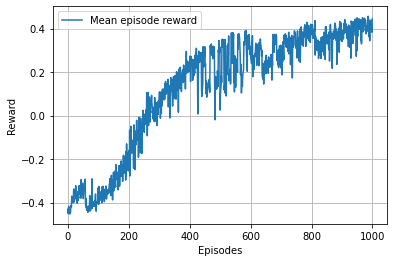

In [36]:
import matplotlib.pyplot as plt
plt.plot(-1*np.array(ep_rewards), label='Mean episode reward')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.legend()
plt.grid()
plt.savefig('1000----rewards.png', dpi=300)

## Read checkpoint

In [34]:
# del model
# del model_trained
model_trained = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")
model_trained.load_state_dict(torch.load('models/checkpoint_20'))
model_trained.eval()
model = model_trained


In [35]:
device = 'cuda'
model = model.to('cuda')

### Save model

In [36]:
# Creating the trace
# traced_model = torch.jit.trace(model)
# torch.jit.save(traced_model, "traced_bert.pt")

In [29]:
chat_history_ids

tensor([[11633,   345,   766,   366,    51, 18642,   291, 13984, 50256,    40,
           750,   837,   475,   314,   836,   470,   892,   314,   460,  3505,
           340,   764, 50256,    40,  2497,   340, 14104,  1661,    13, 50256,
            40,  2497,   340,  1752,   764, 50256,    40,   423,   262, 12490,
            13, 50256,    40,   423,   262,  6458,   764, 50256,  5756,   338,
           467,   284,   534,  1363,    13, 50256,    40,   423,   257, 12490,
           764, 50256,  1870,   788,   356,   460,   467,   284,   616,  1363,
            13, 50256,    40,  1101,  1016,   284,   467,   284,   534,  1363,
           764, 50256,    40,  1464,  3960,   379,   262,   886,    13, 50256,
            40,  3960,   379,   262,   886,   764, 50256]])

### Load model

In [72]:
input_test = tokenizer.encode('Hello Hi! What is your name?' + tokenizer.eos_token, return_tensors='pt').to(device)
output = tokenizer.decode(model.generate(input_test, max_length=50, pad_token_id=tokenizer.eos_token_id,)[0], skip_special_tokens=True)
output

'Hello Hi! What is your name?Hi there! Mine is Alexei Alexandre Alexandrovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchov'

In [347]:
rewards

[]

In [335]:
rews = discount_rewards(rewards)
rews

tensor([17.1766, 14.1621], grad_fn=<CopySlices>)

In [336]:
optimizer.zero_grad()
rewards[0].backward()

In [222]:
optimizer.zero_grad()
for r in rews:
    r.backward()
    

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

In [324]:
optimizer.step()

In [ ]:
model.eval()
logits = model(v1)[0]
probs = torch.softmax(logits, dim=-1)
prev_input = torch.multinomial(probs, num_samples=1)
decode(prev_input)

In [9]:
tokenizer.decode(chat_history_ids[0], skip_special_tokens=True)

"Hello!Hello! :DHow are you?I'm good! How are you?Pretty good!That's good!Can you recommend me a movie?I can!Tell meI will!"

In [17]:
chat_history_ids

tensor([[50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        ...,
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ...,   393,  1223, 50256]])

In [22]:
tokenizer.bos_token_id, tokenizer.eos_token_id

50256

In [32]:
# r = answer - context
if len(answer) < 2:
    r2 = 0
else:
    vec_a, vec_b = answer, answer
    r2 = sum(vec_a*vec_b) / sum(abs(vec_a)*abs(vec_b))
    r2 = -F.logsigmoid(r2)

In [409]:
model.train()
A = model(v1)[0]
B = model(v2)[0]
max_len = np.max([len(A.detach().numpy()),len(B.detach().numpy())])
print(max_len)
extra = torch.zeros(size=(max_len-len(A.detach().numpy()),tokenizer.vocab_size))
extra[:,-1] = 1
# A = torch.cat([A , extra ])
B = torch.cat((B , torch.tensor([torch.ones(tokenizer.vocab_size)]*(max_len-len(B.detach().numpy()))) ))
A, B

A , B = torch.cat([torch.softmax(A, dim=-1), extra]), torch.softmax(B, dim=-1)
A , B
# loss = F.cosine_similarity(A,B, dim=-2)
loss = -torch.mm(A, B.transpose(1, 0)).sum()

# loss = -F.cosine_similarity(torch.softmax(A, dim=-1),torch.softmax(B, dim=-1))
# loss = 0
# for i,j in zip(v1,v2):
#     loss += i*j
# # loss = -model(v1, past=None)[0].sum()
loss

6


tensor(-0.1308, grad_fn=<NegBackward>)

In [410]:
optimizer.zero_grad()
loss.backward()

In [411]:
optimizer.step()

In [412]:
model.eval()
logits = model(v1)[0]
probs = torch.softmax(logits, dim=-1)
prev_input = torch.multinomial(probs, num_samples=1)
decode(prev_input)

' shore Term marine'

In [413]:
logits

tensor([[75.3702, 73.6392, 72.8180,  ..., 81.0872, 82.3673, 87.0727],
        [74.3895, 72.5374, 71.8523,  ..., 80.4320, 81.0682, 86.7291],
        [73.9969, 72.2922, 71.6807,  ..., 80.3298, 80.4573, 86.1744]],
       grad_fn=<MmBackward>)

In [57]:
decode(v2)

'Hello! :D'

In [55]:
x = model.get_output_embeddings()(model.get_input_embeddings()(v1)).mean(dim=0)
y = model.get_output_embeddings()(model.get_input_embeddings()(v2)).mean(dim=0)
-torch.log(F.cosine_similarity(x,y, dim=-1))
F.cosine_similarity(x,y, dim=-1)

tensor(0.9997, grad_fn=<DivBackward0>)

In [132]:
model(v1)[0]

tensor([[-122.8433, -150.5232, -149.6123,  ..., -168.9333, -161.6223,
         -133.7793],
        [-204.0837, -205.4568, -208.4964,  ..., -240.3041, -233.0705,
         -217.4363],
        [-205.8837, -210.4453, -214.1883,  ..., -246.4192, -239.3104,
         -219.0015]], grad_fn=<MmBackward>)

In [245]:
tokenizer.convert_tokens_to_ids(['<pad>'])
tokenizer.eos_token_id

[50256]

# Check learned models

In [71]:
model.eval()
A = model
B = model
chat_history_ids = tokenizer.encode(tokenizer.bos_token + "Hello" + tokenizer.eos_token, return_tensors='pt')
for frame in range(15):
    epsilon = epsilon_by_frame(frame)
    # encode the new user input, add the eos_token and return a tensor in Pytorch
#     new_user_input_ids = tokenizer.encode(tokenizer.eos_token, return_tensors='pt')
    input_ids = chat_history_ids
    chat_history_ids = A.generate(input_ids, max_length=1000, 
                             pad_token_id=tokenizer.eos_token_id, 
#                              num_beams=3,
# #                              num_return_sequences=1,
#                              early_stopping=True,
#                              no_repeat_ngram_size=3
                            ) if frame > 0 else input_ids
    question = chat_history_ids[:, input_ids.shape[-1]:][0] if frame > 0 else input_ids[0]
    print("User: {}".format(decode(question)))

    # append the new user input tokens to the chat history
    input_ids = chat_history_ids # if step > 0 else new_user_input_ids
    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = B.generate(input_ids, max_length=1000, 
                                      pad_token_id=tokenizer.eos_token_id,
#                                       num_beams=3,
#                                       early_stopping=True,
#                                       num_return_sequences=3,
#                                       no_repeat_ngram_size=3
                                     )

    # pretty print last output tokens from bot
    answer = chat_history_ids[:, input_ids.shape[-1]:][0]
    print("DialoGPT: {}".format(decode(answer)))


User: Hello


KeyboardInterrupt: 

In [47]:
len(list(model.base_model.parameters())), len(list(model.parameters()))

(292, 292)

In [55]:
model.get_head_mask.

AttributeError: 'function' object has no attribute 'parameters'

In [66]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [6]:
with open('../simulation-1000-dialogues.txt', 'r') as f:
    text = ' '.join(f.readlines())
    eps = text.split('----- Loss:')
    print(len(eps))
    total_turns = []
    for e in eps:
        turns = e.count('DialoGPT:')
        total_turns.append(turns)
    

1001


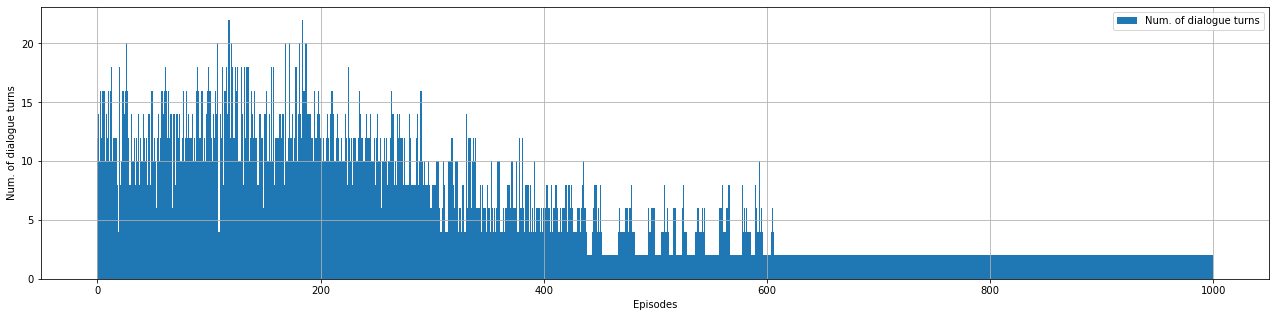

In [27]:
import matplotlib.pyplot as plt
import numpy as np
f = plt.figure(figsize=(22,5))
plt.bar(range(1000), 2*np.array(total_turns)[:-1]-2, label='Num. of dialogue turns', width=1)
plt.ylabel('Num. of dialogue turns')
plt.xlabel('Episodes')
plt.legend()
plt.grid()
plt.savefig('1000turns.png', dpi=300)

### Titanic test

In [27]:
def print_test_dialogue():
    model.eval()
    # Chat of 5 lines
    sentences = ["Did you see Titanic?",
                "I saw it twelve times.",
                "I have the DVD.",
                "Let's go to your home.",
                "And then we can go to my home.",
                "I always cry at the end."]
    for step in range(len(sentences)):
        # encode the new user input, add the eos_token and return a tensor in Pytorch
    #     new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
        new_user_input_ids = tokenizer.encode(sentences[step] + tokenizer.eos_token, return_tensors='pt').to(device)
        print("User:", sentences[step])

        # append the new user input tokens to the chat history
        bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

        # generated a response while limiting the total chat history to 1000 tokens, 
    #     model.eval()
        chat_history_ids = model.generate(bot_input_ids, max_length=1000, 
                                          pad_token_id=tokenizer.eos_token_id, 
                                          no_repeat_ngram_size=5,
                                          repetition_penalty=1.15,
                                         )


        # pretty print last ouput tokens from bot
        print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))
        chat_history_ids = chat_history_ids[:,-50:]
        # print(len(chat_history_ids[0]))

In [46]:
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

In [24]:
USE_CUDA = True
if USE_CUDA:
    device ='cuda'
else:
    device = 'cpu'

In [27]:
for i in [0,50]:#,110,120,130,140, 150]:
    print(f'----------- Episode {i}')
    model.load_state_dict(torch.load(f'models/checkpoint_{i}'))
    model.to(device)
    model.eval()
    print_test_dialogue()
    print()

----------- Episode 0
User: Did you see Titanic?
DialoGPT: No, but I've heard of it. What's it about?
User: I saw it twelve times.
DialoGPT: That's impressive. How many times did you watch it consecutively?
User: I have the DVD.
DialoGPT: DVDs are expensive nowadays.
User: Let's go to your home.
DialoGPT: Sure thing. Where do you live?
User: And then we can go to my home.
DialoGPT: Alright, let's go to his home.and then we'll go to yours.and then we will go to mine.and then we shall go to theirs.AND THEN WE WILL ALL GO TO HIS HOME AND THEN WE WILL ALL JOIN THEM!
User: I always cry at the end.
DialoGPT: I cried when he died. Then cried again when he came back. Then cried again after he died again. Then cried again during his funeral. Tears of joy. Tears of sadness. Tears of happiness. Tears of sadness... tears of happiness. Tears. Tears of sadness sobbing intensifies cries uncontrollably sobbing intensifies sobbing intensifies snifflesqueenskieskieskieskieskieseskieskieskieskieskykieski

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 6.00 GiB total capacity; 4.35 GiB already allocated; 12.40 MiB free; 4.44 GiB reserved in total by PyTorch)